**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Runtime --> Change runtime type***

In [1]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 50 kB 2.0 MB/s 


In [2]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
#print(X_train.shape) # N, H, W, C
X_train = X_train.transpose(0, 3, 1, 2) / 255.0 # N, C, H, W
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

print("Number of training points: {}".format(len(X_train)))
print("Number of validation points: {}".format(len(X_valid)))
print("Number of testing points: {}".format(len(X_test)))

Number of training points: 48000
Number of validation points: 6000
Number of testing points: 6000


### Question 1.1

From the data split, there are 48,000 training points. If 32 training points are sampled at each step of the gradient descent, then it will take 
$\frac{48,000}{32} = 1500$
iterations to go through the entire training set.

An epoch occurs when the entire dataset has been passed through the network. In 30 epochs, there are 
$30\times1500 = 45,000$
iterations


Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



(32, 32, 3)


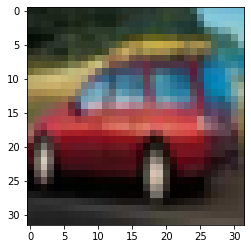

In [ ]:
#Let's plot the first image in the training set.
print(X_train[0].transpose(1,2,0).shape)
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

print("my_image shape: {}".format(my_image.shape))

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Filter shape: {}".format(filter_weights.shape))
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

my_image shape: (1, 3, 32, 32)
Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
Filter shape: (1, 1, 3, 2)
Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.10279882  0.0982345   0.08189839 ...  0.75253254  0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.77934486  0.7626404
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.79253834  0.77845234
     0.775332  ]
   ...
   [ 0.20083015  0.1917015   0.1917015  ...  0

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [ ]:
#Solution to the above problem
def my_conv_net(my_image, initial_filter_weights):
    "PUT YOUR CODE HERE"

    batch_size, c_in, h_in, w_in = my_image.shape
    k, _, c_in, c_out = initial_filter_weights.shape

    my_conv_output = np.zeros((batch_size, c_out, h_in, w_in))
    
    # since k = 1, k - 1 = 0
    # therefore, i and j are equal to 0 and can be hardcoded into the for loops below
    for n in range(batch_size):
        for c in range(c_out):
            for h in range(h_in):
                for w in range(w_in):
                    for c_i in range(c_in):
                        my_conv_output[n][c][h][w] += my_image[n][c_i][h][w] * initial_filter_weights[0][0][c_i][c]
    
    return my_conv_output

my_conv_output = my_conv_net(my_image, filter_weights)

print("My conv net outputs: {}".format(my_conv_output))
print("My conv output shape:", np.shape(my_conv_output))

My conv net outputs: [[[[-0.10271907 -0.10010862 -0.09076816 ... -0.7420423  -0.73912489
    -0.73746228]
   [-0.12882358 -0.11180527 -0.11687266 ... -0.73105443 -0.74346107
    -0.74085063]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.69911373 -0.71740329
    -0.71560836]
   ...
   [-0.11485984 -0.10963892 -0.10963892 ... -0.11178758 -0.11439803
    -0.12222938]
   [-0.09658667 -0.09136577 -0.09136577 ... -0.12745032 -0.12483985
    -0.12483985]
   [-0.08614486 -0.08353443 -0.08614486 ... -0.16399662 -0.16138616
    -0.15355483]]

  [[ 0.10279882  0.09823449  0.08189839 ...  0.75253248  0.7320599
     0.72146261]
   [ 0.14844204  0.12636711  0.1275416  ...  0.7793448   0.76264036
     0.75807607]
   [ 0.15300636  0.12562042  0.15036322 ...  0.7925384   0.7784524
     0.77533197]
   ...
   [ 0.20083013  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.15975127  0.15975127 ...  0.29957128  0.29500696
     0.29500696]
   [ 0.15062262  0.14605829  0

In [ ]:
#Check if conv2d output and my conv function produce the same output
objax_conv = Conv2d(my_image)
print("my_conv_net and Conv2d produce the same output: {}".format(np.allclose(my_conv_output, objax_conv, 1e-7, 1e-7)))

my_conv_net and Conv2d produce the same output: True


The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [ ]:
#Check that .mean((2,3)) rearranges your image
mean = my_conv_output.mean((2,3))
print("my_conv_output.mean: {}".format(mean))
print("shape: {}".format(mean.shape))

my_conv_output.mean: [[-0.1400071   0.35388903]]
shape: (1, 2)


Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [ ]:
#PUT YOUR CODE HERE
lin_layer = objax.nn.Linear(2, 1)
y = lin_layer(mean)

# mean has shape (1, 2)
# lin_layer.w.value has shape (2, 1)
# matrix multiply mean and lin_layer.w.value to obtain output

#my_output = np.matmul(mean, lin_layer.w.value) + lin_layer.b.value
my_output = jn.matmul(mean, lin_layer.w.value) + lin_layer.b.value

print("My linear layer output: {}".format(my_output[0][0]))
print("Objax's linear layer output: {}".format(y[0][0]))

My linear layer output: 0.0347154438495636
Objax's linear layer output: 0.0347154438495636


### Question 1.4

The training set is used to find the optimal values of parameters such as the weight and bias that decrease the training error. These values are updated in the training routine when the training routine calls the loss function. The output of the loss function is then passed to an optimizer function to provide an indication of the direction in which the parameters should be updated.

The validation set, typically a smaller dataset than the training set, is used to tune the hyperparameters. Hyperparameters are values that need to be decided upon before executing the training procedure. When using the validation set, the model's parameters are not updated. 

By using both the training and the validation set, we can ensure that the model generalizes well.

You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      #params.value = params.value - lr * grad
      params.assign(params.value - lr * grad)
      #print("done SGD")                     
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [10]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4, SUPPRESS_OUTPUT=False):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)

      for it in range(0, X_train.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = train_indices[it:it + BATCH]

          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()

      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])
      
      #if not SUPPRESS_OUTPUT: print("Done training")

      # run validation
      val_indices = np.arange(len(X_valid)) 
      #if not SUPPRESS_OUTPUT: print("val indices: {}".format(val_indices))
      np.random.shuffle(val_indices)
      
      for it in range(0, X_valid.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = val_indices[it:it + BATCH]
          
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)

          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()

      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])
      
      #if not SUPPRESS_OUTPUT: print("Done validation")
      
      if not SUPPRESS_OUTPUT:
        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' %\
                (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

  return train_acc_epoch, val_acc_epoch

Epoch 0001  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 12.90 Validation Accuracy 13.22
Epoch 0002  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 13.37 Validation Accuracy 13.48
Epoch 0003  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 13.55 Validation Accuracy 13.87
Epoch 0004  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 14.14 Validation Accuracy 13.92
Epoch 0005  Training Loss 2.24 Validation Loss 2.24 Training Accuracy 14.39 Validation Accuracy 14.80
Epoch 0006  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 15.20 Validation Accuracy 15.17
Epoch 0007  Training Loss 2.23 Validation Loss 2.22 Training Accuracy 15.83 Validation Accuracy 16.68
Epoch 0008  Training Loss 2.22 Validation Loss 2.22 Training Accuracy 16.69 Validation Accuracy 17.42
Epoch 0009  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 17.43 Validation Accuracy 17.40
Epoch 0010  Training Loss 2.21 Validation Loss 2.20 Training Accuracy 18.38 Valida

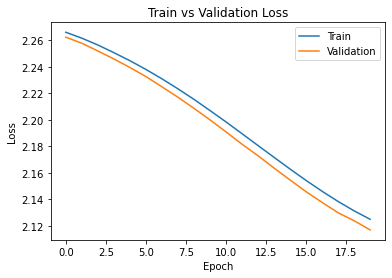

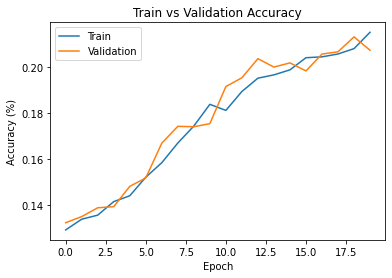

In [ ]:
base_train_acc, base_val_acc = train()

Follow the assignment handout for questions to be answered in this part of the assignment.

### Question 2.4

A hyperparameter is a parameter that is pre-selected before training for which the model will not find/optimize the value during training. 

The values of the parameters are chosen by the model when training on the training set. Hyperparameters are chosen by the designer. Their performance is tested by creating different models that use each set of hyperparameter assignments and evaluating each model's performance on the validation set. We pick the hyperparameter settings which result in the highest validation accuracy (or lowest validation loss).

Only when we are sufficiently confident in our model's performance using these parameter and hyperparameter values (because the model achieves a satisfactory training and validation accuracy) do we examine how well the model generalizes to never-before-seen data in the test set. 

If you test the model on the test set before you have finished picking hyperparameters, then the accuracy reported is not a good representation of the model's ability to generalize to unseen data.

### Question 2.5
https://objax.readthedocs.io/en/latest/notebooks/Custom_Networks.html

The 4 hyperparameters that I chose to tune are: learning rate, number of convolution layers, number of fully-connected layers, and number of inputs to the first convolutional layer.

$H_{1} = [0.001, 2, 1, 32]$

$H_{2} = [0.0001, 3, 2, 64]$

### Question 2.6

In [5]:
h1 = {"lr" : 0.001,
      "conv_three_layers" : False,
      "fc_two_layers" : False,
      "n": 32}

h2 = {"lr" : 0.0001,
      "conv_three_layers" : True,
      "fc_two_layers" : True,
      "n" : 64}

In [6]:
class ConvNet_HyperparameterSearch(objax.Module):
  def __init__(self, n, conv_three_layers, fc_two_layers, number_of_channels = 3, number_of_classes = 10):
    self.conv_three_layers = conv_three_layers
    self.fc_two_layers = fc_two_layers
    
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, n, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(1 * n, 2 * n, 2), objax.functional.relu])
    
    if conv_three_layers:
        self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(2 * n, 4 * n, 2), objax.functional.relu])
        conv_out = 4*n
    else:
        conv_out = 2*n

    if fc_two_layers:
        self.linear1 = objax.nn.Linear(conv_out, 2 * n)
        self.linear2 = objax.nn.Linear(2 * n, number_of_classes)
    else:
        self.linear1 = objax.nn.Linear(conv_out, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_2(x)

    if self.conv_three_layers and self.fc_two_layers: 
        x = objax.functional.max_pool_2d(x, 2, 2)
        x = self.conv_3(x)
  
    x = x.mean((2,3)) #<--- global average pooling 

    if self.fc_two_layers:
        x = self.linear1(x)
        x = self.linear2(x)
    else:
        x = self.linear1(x)
    
    return x

In [ ]:
# testing model 2 which uses hyperparameters h2
model = ConvNet_HyperparameterSearch(n=h2["n"], conv_three_layers=h2["conv_three_layers"], fc_two_layers=h2["fc_two_layers"])
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      #params.value = params.value - lr * grad
      params.assign(params.value - lr * grad)
      #print("done SGD")                     
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

Training model 2 using H2
Epoch 0001  Training Loss 2.32 Validation Loss 2.30 Training Accuracy 8.91 Validation Accuracy 6.33
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.14 Validation Accuracy 9.05
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.41 Validation Accuracy 11.12
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.56 Validation Accuracy 10.98
Epoch 0005  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 10.80 Validation Accuracy 11.43
Epoch 0006  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.28 Validation Accuracy 11.95
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.85 Validation Accuracy 12.25
Epoch 0008  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 12.52 Validation Accuracy 12.58
Epoch 0009  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.98 Validation Accuracy 13.33
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training 

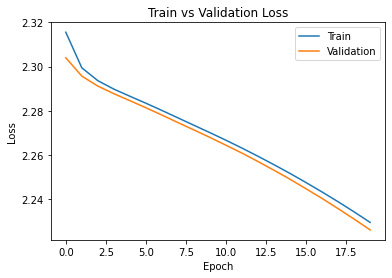

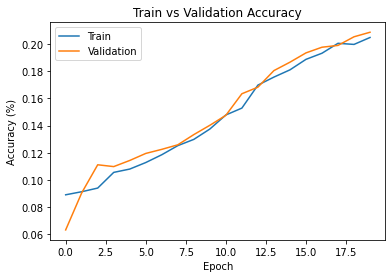

In [ ]:
print("Training model 2 using H2")
m2_train_acc, m2_val_acc = train(LEARNING_RATE=h2["lr"])

In [7]:
# testing model 1 which uses hyperparameters h1
model = ConvNet_HyperparameterSearch(n=h1["n"], conv_three_layers=h1["conv_three_layers"], fc_two_layers=h1["fc_two_layers"])
#You can examine the architecture of our CNN by calling model.vars()

In [8]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      #params.value = params.value - lr * grad
      params.assign(params.value - lr * grad)
      #print("done SGD")                     
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

Training model 1 using H1
Epoch 0001  Training Loss 2.29 Validation Loss 2.27 Training Accuracy 11.18 Validation Accuracy 14.17
Epoch 0002  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 14.27 Validation Accuracy 16.77
Epoch 0003  Training Loss 2.24 Validation Loss 2.22 Training Accuracy 16.80 Validation Accuracy 18.38
Epoch 0004  Training Loss 2.22 Validation Loss 2.20 Training Accuracy 18.37 Validation Accuracy 18.23
Epoch 0005  Training Loss 2.19 Validation Loss 2.18 Training Accuracy 19.19 Validation Accuracy 19.35
Epoch 0006  Training Loss 2.18 Validation Loss 2.16 Training Accuracy 19.89 Validation Accuracy 19.65
Epoch 0007  Training Loss 2.16 Validation Loss 2.14 Training Accuracy 20.50 Validation Accuracy 20.25
Epoch 0008  Training Loss 2.14 Validation Loss 2.13 Training Accuracy 20.89 Validation Accuracy 20.38
Epoch 0009  Training Loss 2.13 Validation Loss 2.12 Training Accuracy 21.30 Validation Accuracy 22.55
Epoch 0010  Training Loss 2.12 Validation Loss 2.11 Trai

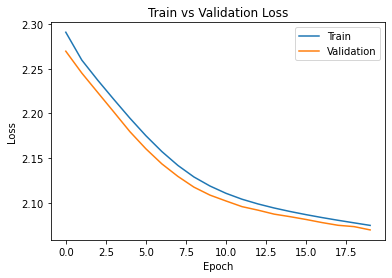

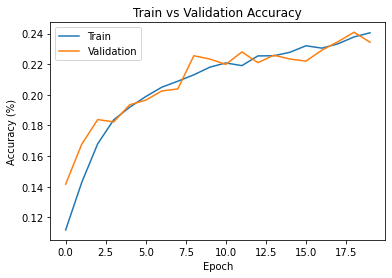

In [11]:
print("Training model 1 using H1")
m1_train_acc, m1_val_acc = train(LEARNING_RATE=h1["lr"])

In [ ]:
def find_highest_acc_and_epoch(a_list):
    highest_acc = max(a_list)
    epoch = a_list.index(highest_acc)

    return highest_acc*100, epoch + 1

m1_highest_val_acc, m1_epoch = find_highest_acc_and_epoch(m1_val_acc)
m2_highest_val_acc, m2_epoch = find_highest_acc_and_epoch(m2_val_acc)
base_highest_val_acc, base_epoch = find_highest_acc_and_epoch(base_val_acc)

print("Base model: {}% at epoch {}".format(base_highest_val_acc, base_epoch))
print("M1: {}% at epoch {}".format(m1_highest_val_acc, m1_epoch))
print("M2: {}% at epoch {}".format(m2_highest_val_acc, m2_epoch))

Base model: 21.316666666666666% at epoch 19
M1: 21.383333333333333% at epoch 19
M2: 20.849999999999998% at epoch 20


### Question 2.7
Since model M1 has the highest validation accuracy, we pick this model and its associated hyperpararmeters as the model on which the test dataset will be run.

For the sake of time, I only ran the models for 20 epochs. However, the accuracy of the base model, M1, and M2 do not appear to plateau as the number of epochs approaches 20. This suggests that, by running the training procedure for more epochs, you could achieve a higher accuracy.

In [ ]:
# Since M1 was the model which was most recently run, we can directly run the testing loop

BATCH = 32
avg_test_loss = 0
test_acc = 0
test_indices = np.arange(len(X_test))

#if not SUPPRESS_OUTPUT: print("val indices: {}".format(val_indices))
np.random.shuffle(test_indices)

for it in range(0, X_test.shape[0], BATCH):
    #PUT YOUR CODE HERE#
    batch = test_indices[it:it + BATCH]
    
    avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
    test_prediction = predict(X_test[batch]).argmax(1)

    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()

print('Model M1 test accuracy: %.2f' % (test_acc/X_test.shape[0] * 100))

Model M1 test accuracy: 20.77


You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**


### Question 3.1
Dataset chosen: fashion_mnist
https://www.tensorflow.org/datasets/catalog/fashion_mnist

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()
#print(X_train.shape) # (60000, 28, 28)

# X_train and X_test have shape (60000, 28, 28)
# need to re-shape it to (60000, 28, 28, 1) to work on our CNN
X_train = np.expand_dims(X_train, 1)
X_train = X_train.astype(np.float32)
X_test = np.expand_dims(X_test, 1)
X_test = X_test.astype(np.float32)

# proceed with pre-processing as in Part 1
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

# a pre-split training/validation/testing allocation
np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

print("Number of training points: {}".format(len(X_train)))
print("Number of validation points: {}".format(len(X_valid)))
print("Number of testing points: {}".format(len(X_test)))

Number of training points: 56000
Number of validation points: 7000
Number of testing points: 7000


(28, 28, 1)
(28, 28)


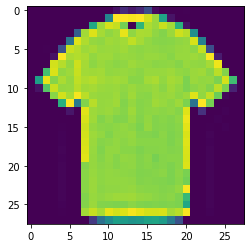

In [ ]:
#Let's plot the first image in the training set.
print(X_train[0].transpose(1,2,0).shape)
#plt.imshow(X_train[0].transpose(1,2,0))
plt.imshow(np.squeeze(X_train[0].transpose(1,2,0)))
print(np.squeeze(X_train[0].transpose(1,2,0)).shape)

### Question 3.2

In [ ]:
class ConvNet_Fashion_MNIST(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet_Fashion_MNIST(number_of_channels=1)
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      #params.value = params.value - lr * grad
      params.assign(params.value - lr * grad)
      #print("done SGD")                     
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

Training Fashion MNIST base model
Epoch 0001  Training Loss 1.73 Validation Loss 1.22 Training Accuracy 50.39 Validation Accuracy 58.83
Epoch 0002  Training Loss 1.13 Validation Loss 1.04 Training Accuracy 66.59 Validation Accuracy 65.39
Epoch 0003  Training Loss 1.01 Validation Loss 0.97 Training Accuracy 70.29 Validation Accuracy 67.04
Epoch 0004  Training Loss 0.94 Validation Loss 0.91 Training Accuracy 72.11 Validation Accuracy 68.46
Epoch 0005  Training Loss 0.90 Validation Loss 0.92 Training Accuracy 73.40 Validation Accuracy 66.97
Epoch 0006  Training Loss 0.87 Validation Loss 0.85 Training Accuracy 74.24 Validation Accuracy 71.71
Epoch 0007  Training Loss 0.84 Validation Loss 0.83 Training Accuracy 75.25 Validation Accuracy 72.69
Epoch 0008  Training Loss 0.83 Validation Loss 0.79 Training Accuracy 75.47 Validation Accuracy 73.94
Epoch 0009  Training Loss 0.81 Validation Loss 0.77 Training Accuracy 76.11 Validation Accuracy 73.47
Epoch 0010  Training Loss 0.79 Validation Loss 0

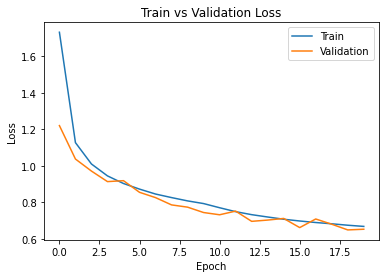

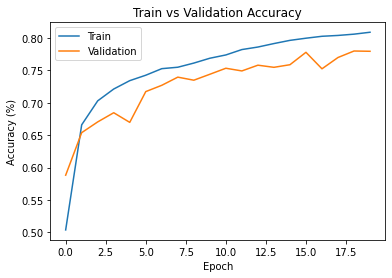

In [ ]:
# train base model
print("Training Fashion MNIST base model")
base_train_acc, base_val_acc = train()

### Question 3.3
Some hyperparameters that you can tune:

*   Number of convolutional layers (*)
*   Number of fully-connected layers
*   Number of outputs of each convolutional layer (*)
*   Convolutional kernel size (*)
*   Optimizer
*   Activation function
*   Learning rate (*)
*   Batch size (*)

The hyperparameters that I tuned have a (*) next to them

Model One
*   Number of convolutional layers: 2
*   Number of outputs of each convolutional layer: 16, 32 (respectively)
*   Convolutional kernel size: 3
*   Learning rate: 0.0001
*   Batch size = 32

In [ ]:
class ConvNet_Model_One(objax.Module):
  def __init__(self, n, k, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 1 * n, k), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(1 * n, 2 * n, k), objax.functional.relu])
    self.linear = objax.nn.Linear(2 * n, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet_Model_One(n=16, k=3)
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      #params.value = params.value - lr * grad
      params.assign(params.value - jn.multiply(lr, grad))
      #print("done SGD")                     
    return loss_value                      # return loss value

Training Fashion MNIST Model M1
Epoch 0001  Training Loss 2.50 Validation Loss 1.33 Training Accuracy 45.62 Validation Accuracy 56.53
Epoch 0002  Training Loss 1.23 Validation Loss 1.13 Training Accuracy 62.18 Validation Accuracy 61.37
Epoch 0003  Training Loss 1.07 Validation Loss 1.05 Training Accuracy 67.25 Validation Accuracy 64.64
Epoch 0004  Training Loss 0.98 Validation Loss 0.92 Training Accuracy 70.20 Validation Accuracy 69.01
Epoch 0005  Training Loss 0.91 Validation Loss 0.86 Training Accuracy 72.30 Validation Accuracy 71.46
Epoch 0006  Training Loss 0.87 Validation Loss 0.83 Training Accuracy 73.92 Validation Accuracy 72.27
Epoch 0007  Training Loss 0.83 Validation Loss 0.82 Training Accuracy 74.90 Validation Accuracy 72.63
Epoch 0008  Training Loss 0.80 Validation Loss 0.77 Training Accuracy 75.77 Validation Accuracy 74.37
Epoch 0009  Training Loss 0.78 Validation Loss 0.76 Training Accuracy 76.44 Validation Accuracy 74.40
Epoch 0010  Training Loss 0.76 Validation Loss 0.7

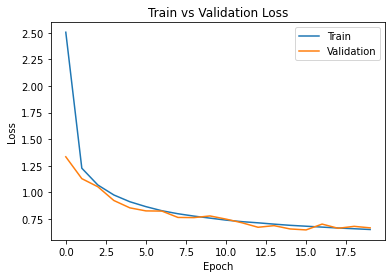

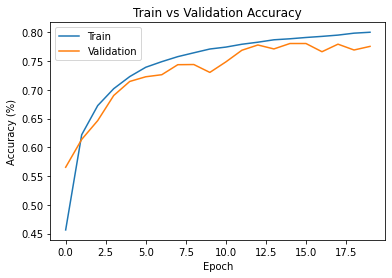

In [ ]:
print("Training Fashion MNIST Model M1")
m1_train_acc, m1_val_acc = train(LEARNING_RATE=0.0001)

Model Two
*   Number of convolutional layers: 3
*   Number of outputs of each convolutional layer: 16, 32, 64 (respectively)
*   Convolutional kernel size: 3
*   Learning rate: 0.001
*   Batch size = 64

In [ ]:
class ConvNet_Model_Two(objax.Module):
  def __init__(self, n, k, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 1 * n, k), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(1 * n, 2 * n, k), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(2 * n, 4 * n, k), objax.functional.relu])
    self.linear = objax.nn.Linear(4 * n, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_2(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_3(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet_Model_Two(n=16, k=3)
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      #params.value = params.value - lr * grad
      params.assign(params.value - jn.multiply(lr, grad))
      #print("done SGD")                     
    return loss_value                      # return loss value

Training Fashion MNIST Model M2
Epoch 0001  Training Loss 0.44 Validation Loss 0.44 Training Accuracy 86.46 Validation Accuracy 85.36
Epoch 0002  Training Loss 0.43 Validation Loss 0.44 Training Accuracy 87.05 Validation Accuracy 84.41
Epoch 0003  Training Loss 0.42 Validation Loss 0.42 Training Accuracy 87.29 Validation Accuracy 85.87
Epoch 0004  Training Loss 0.41 Validation Loss 0.41 Training Accuracy 87.57 Validation Accuracy 85.90
Epoch 0005  Training Loss 0.41 Validation Loss 0.41 Training Accuracy 87.97 Validation Accuracy 85.77
Epoch 0006  Training Loss 0.40 Validation Loss 0.40 Training Accuracy 88.12 Validation Accuracy 86.79
Epoch 0007  Training Loss 0.39 Validation Loss 0.43 Training Accuracy 88.28 Validation Accuracy 84.63
Epoch 0008  Training Loss 0.39 Validation Loss 0.41 Training Accuracy 88.56 Validation Accuracy 85.91
Epoch 0009  Training Loss 0.38 Validation Loss 0.40 Training Accuracy 88.70 Validation Accuracy 86.64
Epoch 0010  Training Loss 0.38 Validation Loss 0.3

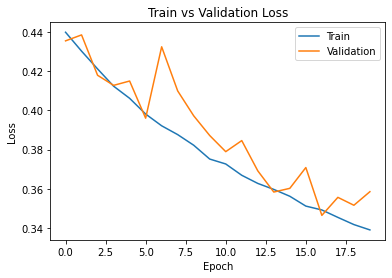

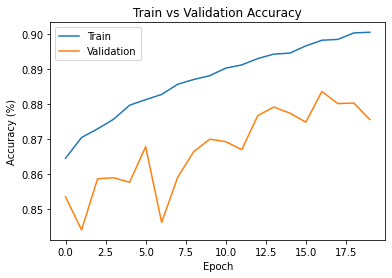

In [ ]:
print("Training Fashion MNIST Model M2")
m2_train_acc, m2_val_acc = train(LEARNING_RATE=0.001, BATCH=64)

In [ ]:
m1_highest_val_acc, m1_epoch = find_highest_acc_and_epoch(m1_val_acc)
m2_highest_val_acc, m2_epoch = find_highest_acc_and_epoch(m2_val_acc)
base_highest_val_acc, base_epoch = find_highest_acc_and_epoch(base_val_acc)

print("Base model: {}% at epoch {}".format(base_highest_val_acc, base_epoch))
print("M1: {}% at epoch {}".format(m1_highest_val_acc, m1_epoch))
print("M2: {}% at epoch {}".format(m2_highest_val_acc, m2_epoch))

Base model: 77.97142857142858% at epoch 19
M1: 78.05714285714286% at epoch 15
M2: 88.35714285714286% at epoch 17


**Discussion of Hyperparameter Tuning**

The hyperparameters that I chose to tune were:
*   Number of convolutional layers
*   Number of outputs of convolutional layer
*   Convolutional kernel size
*   Learning rate
*   Batch size

My base model was a 2-layer CNN with 16 hidden output units in the first convolution layer and 32 hidden output units in the second convolutional layer. The convolution was done with a 2x2 kernel. The output of the final convolutional layer was fed to one fully-connected layer. The validation accuracy of this model was approximately 78%.

The hyperparameter change which I made to M1 was to increase the convolutional kernel size from 2x2 to 3x3. I chose to increase the kernel size to see whether more information about the image's pixels could be shared among the weights in the following layer. All other hyperparameters stayed the same. The validation accuracy of this model was approximately 78%, which was about the my base model. This was to be expected, as there wasn't a large shift in the architecture or hyperparameter values between the base model and M1.

In M2 I decided to re-work the convolutional architecture of M1 by increasing the number of convolutional layers from 2 layers to 3 layers, and the number of fully-connected layers from 1 layer to 2 layers. By increasing the number of convolutional layers, more features can be extracted from the images. Similarly, more fully-connected layers allows these layers to process higher-dimensional output from the convolutional layers. I also increased the learning rate from 0.0001 to 0.001, and the batch size from 32 to 64 to promote the model learning features more quickly. This model achieved a validation accuracy of around 88%, which is about 13% higher than the accuracy of my base model.

Since the validation accuracy of M2 reached a plateau within a few epochs, this suggests that the accuracy likely cannot reach a higher value. Therefore, M2's hyperparameters should achieve the highest test accuracy out of all tested models.

### Question 3.4
Final model's hyperparameters: 
*   Number of convolutional layers: 3
*   Number of fully-connected layers: 1
*   Number of outputs of each convolutional layer: 16, 32, 64 (respectively)
*   Convolutional kernel size: 3
*   Optimizer: SGD
*   Activation function: ReLU
*   Learning rate: 0.001
*   Batch size: 64

In [ ]:
# Since M2 was the model which was most recently run, we can directly run the testing loop
BATCH = 64
avg_test_loss = 0
test_acc = 0
test_indices = np.arange(len(X_test))

#if not SUPPRESS_OUTPUT: print("val indices: {}".format(val_indices))
np.random.shuffle(test_indices)

for it in range(0, X_test.shape[0], BATCH):
    #PUT YOUR CODE HERE#
    batch = test_indices[it:it + BATCH]
    
    avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
    test_prediction = predict(X_test[batch]).argmax(1)

    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()

print('Model M2 test accuracy: %.2f' % (test_acc/X_test.shape[0] * 100))

Model M2 test accuracy: 87.07


##**Problem 4. Open-Ended Exploration**

### Question 4.1
**Question to be addressed:** How do optimizers compare?

**Dataset chosen:** CIFAR-10 (same as in Problem 2)

In [3]:
# reload CIFAR-10 dataset

#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
#print(X_train.shape) # N, H, W, C
X_train = X_train.transpose(0, 3, 1, 2) / 255.0 # N, C, H, W
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

print("Number of training points: {}".format(len(X_train)))
print("Number of validation points: {}".format(len(X_valid)))
print("Number of testing points: {}".format(len(X_test)))

170508288/170498071 [==============================] - 6s 0us/step
Number of training points: 48000
Number of validation points: 6000
Number of testing points: 6000


**First optimizer:** objax.optimizer.Momentum

**Momentum Optimizer Optimization Routine**

Momentum is a variation on SGD which remembers the update $\Delta$w at each iteration. The update rule in Momentum uses a velocity term, which accumulates past gradients through a weighted moving average calculation. This means that the next update is calculated as a linear combination of the current gradient and the previous update:

$w := w + -\eta\nabla(Q_{i}(w)) + \alphaΔw$

where $w$ (estimated) is optimized to minimize $Q(w)$, $\eta$ is the learning rate, and $\alpha$ is the exponential decay factor/velocity (between 0 and 1) that determines the effect of the current gradient and earlier gradients on the weight change.

**Momentum Optimizer Implementation Rationale**

Momentum is much faster and more computationally efficient than SGD. Objax's Momentum function also contains the Nesterov's Accelerated Gradient (NAG) optimization method. NAG works by "looking ahead" to where the parameters will be, and uses this information to calculate the gradient ex post rather than ex ante.

The NAG update can be written as: 

$v_{k} = μv_{k - 1} + \nabla f(.;w_{k - 1} + μv_{k - 1})$
$w_{k} = w_{k - 1} - η v_{k}$

where μ (which corresponds to $η$ in Momentum) is usually set to 0.9. 

NAG can have a better convergence rate than gradient descent in some situations.

**Momentum Optimizer Hyperparameters**

momentum - the rate at which past gradients are forgotten

learning rate - the factor by which the current weights should affect the update

nesterov (bool) - if True, the optimizer will use NAG

**References**

https://objax.readthedocs.io/en/latest/objax/optimizer.html#objax.optimizer.Momentum

https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum

https://paperswithcode.com/method/nesterov-accelerated-gradient

In [12]:
# use model M1 from Part 2 with momentum optimizer
model = ConvNet_HyperparameterSearch(n=h1["n"], conv_three_layers=h1["conv_three_layers"], fc_two_layers=h1["fc_two_layers"])

# momentum optimizer
mom_opt = objax.optimizer.Momentum(model.vars())

def loss_function(x, label):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()

gv = objax.GradValues(loss_function, model.vars())

def train_op(x, y, lr):
    g, v = gv(x, y)
    mom_opt(lr, g)
    return v

# JIT the training and prediction functions
train_op = objax.Jit(train_op, gv.vars())
predict = objax.Jit(objax.nn.Sequential([objax.ForceArgs(model), objax.functional.softmax]))

Epoch 0001  Training Loss 2.31 Validation Loss 2.29 Training Accuracy 10.78 Validation Accuracy 10.73
Epoch 0002  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.43 Validation Accuracy 12.68
Epoch 0003  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 12.95 Validation Accuracy 14.88
Epoch 0004  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 14.72 Validation Accuracy 14.75
Epoch 0005  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 15.11 Validation Accuracy 16.12
Epoch 0006  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 16.48 Validation Accuracy 17.22
Epoch 0007  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 18.18 Validation Accuracy 17.77
Epoch 0008  Training Loss 2.20 Validation Loss 2.19 Training Accuracy 19.55 Validation Accuracy 19.80
Epoch 0009  Training Loss 2.19 Validation Loss 2.18 Training Accuracy 20.36 Validation Accuracy 20.52
Epoch 0010  Training Loss 2.17 Validation Loss 2.16 Training Accuracy 20.98 Valida

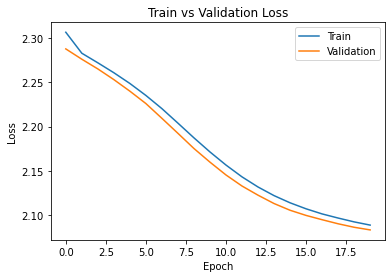

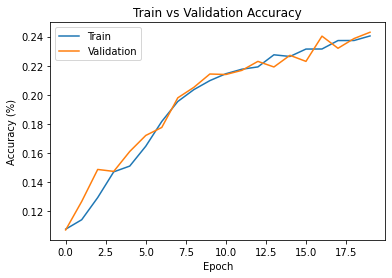

In [13]:
mom_base_train_acc, mom_base_val_acc = train(LEARNING_RATE=0.001, BATCH=32)

In [14]:
# use model M1 from Part 2 with Momentum optimizer
model = ConvNet_HyperparameterSearch(n=h1["n"], conv_three_layers=h1["conv_three_layers"], fc_two_layers=h1["fc_two_layers"])

# Momentum optimizer
mom_opt = objax.optimizer.Momentum(model.vars(), momentum=0.7)

def loss_function(x, label):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()

gv = objax.GradValues(loss_function, model.vars())

def train_op(x, y, lr):
    g, v = gv(x, y)
    mom_opt(lr, g)
    return v

# JIT the training and prediction functions
train_op = objax.Jit(train_op, gv.vars())
predict = objax.Jit(objax.nn.Sequential([objax.ForceArgs(model), objax.functional.softmax]))

Momentum optimizer using momentum = 0.7
Epoch 0001  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 10.44 Validation Accuracy 10.18
Epoch 0002  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 13.65 Validation Accuracy 15.73
Epoch 0003  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 15.57 Validation Accuracy 15.70
Epoch 0004  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 16.57 Validation Accuracy 16.48
Epoch 0005  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 16.74 Validation Accuracy 18.02
Epoch 0006  Training Loss 2.24 Validation Loss 2.24 Training Accuracy 17.64 Validation Accuracy 18.03
Epoch 0007  Training Loss 2.23 Validation Loss 2.22 Training Accuracy 17.87 Validation Accuracy 17.63
Epoch 0008  Training Loss 2.21 Validation Loss 2.21 Training Accuracy 18.41 Validation Accuracy 18.78
Epoch 0009  Training Loss 2.20 Validation Loss 2.19 Training Accuracy 18.61 Validation Accuracy 18.95
Epoch 0010  Training Loss 2.18 Validation 

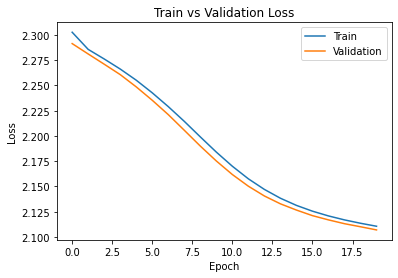

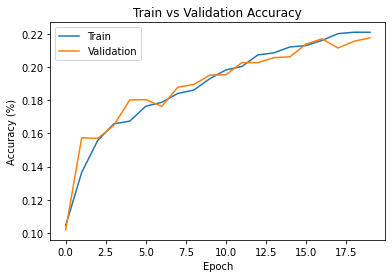

In [15]:
print("Momentum optimizer using momentum = 0.7")
mom_m1_train_acc, mom_m1_val_acc = train(LEARNING_RATE=0.001, BATCH=32)

In [16]:
# use model M1 from Part 2 with Momentum optimizer
model = ConvNet_HyperparameterSearch(n=h1["n"], conv_three_layers=h1["conv_three_layers"], fc_two_layers=h1["fc_two_layers"])

# Momentum optimizer
mom_opt = objax.optimizer.Momentum(model.vars(), nesterov=True)

def loss_function(x, label):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()

gv = objax.GradValues(loss_function, model.vars())

def train_op(x, y, lr):
    g, v = gv(x, y)
    mom_opt(lr, g)
    return v

# JIT the training and prediction functions
train_op = objax.Jit(train_op, gv.vars())
predict = objax.Jit(objax.nn.Sequential([objax.ForceArgs(model), objax.functional.softmax]))

Momentum optimizer using nesterov = True
Epoch 0001  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 11.44 Validation Accuracy 12.47
Epoch 0002  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 14.10 Validation Accuracy 16.10
Epoch 0003  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 17.23 Validation Accuracy 18.12
Epoch 0004  Training Loss 2.22 Validation Loss 2.20 Training Accuracy 19.00 Validation Accuracy 19.93
Epoch 0005  Training Loss 2.19 Validation Loss 2.17 Training Accuracy 19.97 Validation Accuracy 19.27
Epoch 0006  Training Loss 2.16 Validation Loss 2.14 Training Accuracy 20.35 Validation Accuracy 21.58
Epoch 0007  Training Loss 2.14 Validation Loss 2.13 Training Accuracy 20.95 Validation Accuracy 20.68
Epoch 0008  Training Loss 2.12 Validation Loss 2.11 Training Accuracy 21.51 Validation Accuracy 21.15
Epoch 0009  Training Loss 2.11 Validation Loss 2.10 Training Accuracy 21.64 Validation Accuracy 21.05
Epoch 0010  Training Loss 2.10 Validation

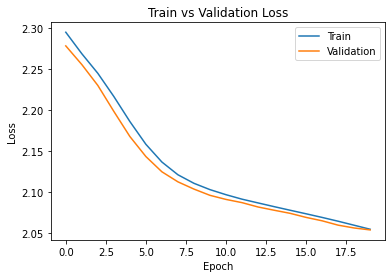

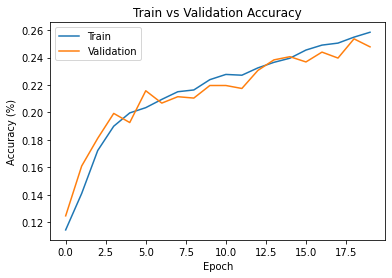

In [17]:
print("Momentum optimizer using nesterov = True")
mom_m1_train_acc, mom_m1_val_acc = train(LEARNING_RATE=0.001, BATCH=32)

**Base model:** momentum = 0.9, nesterov = False, learning_rate = 0.001, batch size = 32

Highest validation accuracy: around 24%


**M1:** momentum = 0.7, nesterov = False, learning_rate = 0.001, batch size = 32

Highest validation accuracy: around 22%

**M2:** momentum = 0.9, nesterov = True, learning_rate = 0.001, batch size = 32

Highest validation accuracy: around 26%

After running the base model and tuning hyperparameters in models M1 and M2, I determined that the validation accuracy is highest when using momentum = 0.9 and Nesterov = True, with learning_rate = 0.001 and batch size = 32. This model achieved a validation accuracy of 26%.

The accuracy of the model while using the Momentum optimizer is comparable to SGD. However, the training procedure was executed a lot faster compared to SGD.

**Second optimizer:** objax.optimizer.Adam

**Adam Optimizer Optimization Routine**

Adam is a variation on stochastic gradient descent which uses adaptive estimation of first-order (the gradient) and second-order (the squared gradient) moments to update the parameters.

The Adam algorithm first computes the gradient $g_{t}$ of the loss function with respect to the weights, and then it computes and remembers the first and second order moments of the gradient $m_{t}$ and $v_{t}$, respectively. This is shown in the following equations:

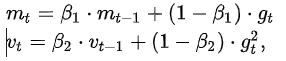

$\beta_{1}$ and $\beta_{2}$, are hyperparameters which control the exponential decay rates of the first and second moments, respectively. Their values are between 0 and 1.

Initially, both $m_{0}$ and $v_{0}$ are initialized to 0, so the values $m_{t}$ and $v_{t}$ are biased towards 0 at small timesteps t. To counter this, the Adam optimizer's authors proposed a corrected update to $m_{t}$ and $v_{t}$, which is as follows: 

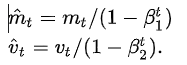

The weight update rule is computed as 

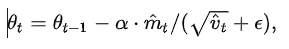

where $ϵ$ is a small constant to prevent division by 0 (and thus to increase computational stability).

**Adam Optimizer Implementation Rationale**

Adam is computationally efficient, has low memory requirements, is invariant to gradient rescaling, and is ideally suited for problems which have a large number of datapoints or hyperparameters.

**Adam Optimizer Hyperparameters**

learning rate - the factor by which the current weights should affect the update

$\beta_{1}$ - the decay/"forgetting factor" for the first moment

$\beta_{2}$ - the decay/"forgetting factor" for the second moment

$ϵ$ - used to prevent division by 0

**References**

https://objax.readthedocs.io/en/latest/objax/optimizer.html#objax.optimizer.Adam

https://arxiv.org/abs/1412.6980

https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam

https://optimization.cbe.cornell.edu/index.php?title=Adam

In [31]:
# use model M1 from Part 2 with Adam optimizer
model = ConvNet_HyperparameterSearch(n=h1["n"], conv_three_layers=h1["conv_three_layers"], fc_two_layers=h1["fc_two_layers"])

# use Adam optimizer
adam_opt = objax.optimizer.Adam(model.vars())

def loss_function(x, label):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()

gv = objax.GradValues(loss_function, model.vars())

def train_op(x, y, lr):
    g, v = gv(x, y)
    adam_opt(lr=lr, grads=g)
    return v

# JIT the training and prediction functions
train_op = objax.Jit(train_op, gv.vars())
predict = objax.Jit(objax.nn.Sequential([objax.ForceArgs(model), objax.functional.softmax]))

Adam optimizer using default hyperparameter values
Epoch 0001  Training Loss 2.09 Validation Loss 1.99 Training Accuracy 26.14 Validation Accuracy 26.95
Epoch 0002  Training Loss 1.94 Validation Loss 1.92 Training Accuracy 32.40 Validation Accuracy 28.82
Epoch 0003  Training Loss 1.86 Validation Loss 1.82 Training Accuracy 35.64 Validation Accuracy 32.23
Epoch 0004  Training Loss 1.81 Validation Loss 1.82 Training Accuracy 37.31 Validation Accuracy 33.17
Epoch 0005  Training Loss 1.77 Validation Loss 1.75 Training Accuracy 38.89 Validation Accuracy 34.15
Epoch 0006  Training Loss 1.74 Validation Loss 1.75 Training Accuracy 39.58 Validation Accuracy 34.28
Epoch 0007  Training Loss 1.72 Validation Loss 1.78 Training Accuracy 40.61 Validation Accuracy 34.95
Epoch 0008  Training Loss 1.70 Validation Loss 1.68 Training Accuracy 41.59 Validation Accuracy 37.98
Epoch 0009  Training Loss 1.68 Validation Loss 1.67 Training Accuracy 42.60 Validation Accuracy 37.18
Epoch 0010  Training Loss 1.66 

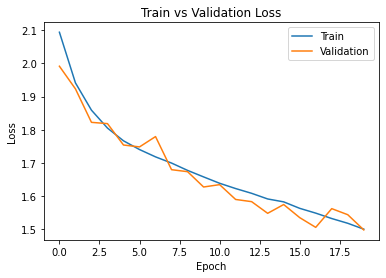

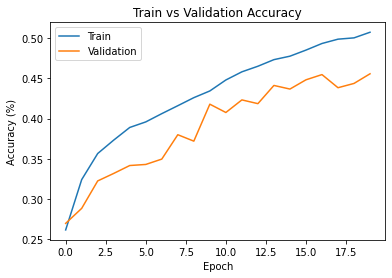

In [32]:
print("Adam optimizer using default hyperparameter values")
adam_base_train_acc, adam_base_val_acc = train(LEARNING_RATE=0.001, BATCH=32)

In [33]:
# Adam optimizer hyperparameter tuning
# M2
# B1 = 0.8
# B2 = 0.955

# use model M1 from Part 2 with Adam optimizer
model = ConvNet_HyperparameterSearch(n=h1["n"], conv_three_layers=h1["conv_three_layers"], fc_two_layers=h1["fc_two_layers"])

# use Adam optimizer
adam_opt = objax.optimizer.Adam(model.vars(), beta1=0.8, beta2=0.955)

def loss_function(x, label):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()

gv = objax.GradValues(loss_function, model.vars())

def train_op(x, y, lr):
    g, v = gv(x, y)
    adam_opt(lr=lr, grads=g)
    return v

# JIT the training and prediction functions
train_op = objax.Jit(train_op, gv.vars())
predict = objax.Jit(objax.nn.Sequential([objax.ForceArgs(model), objax.functional.softmax]))

Adam optimizer using B1 = 0.8 and B2 = 0.955, learning_rate = 0.005
Epoch 0001  Training Loss 2.07 Validation Loss 2.32 Training Accuracy 30.04 Validation Accuracy 21.75
Epoch 0002  Training Loss 2.24 Validation Loss 2.39 Training Accuracy 29.97 Validation Accuracy 24.63
Epoch 0003  Training Loss 2.23 Validation Loss 2.17 Training Accuracy 33.33 Validation Accuracy 26.60
Epoch 0004  Training Loss 2.28 Validation Loss 2.32 Training Accuracy 33.00 Validation Accuracy 27.38
Epoch 0005  Training Loss 2.40 Validation Loss 2.71 Training Accuracy 34.28 Validation Accuracy 27.35
Epoch 0006  Training Loss 3.26 Validation Loss 4.57 Training Accuracy 29.66 Validation Accuracy 24.02
Epoch 0007  Training Loss 4.79 Validation Loss 4.81 Training Accuracy 24.65 Validation Accuracy 17.68
Epoch 0008  Training Loss 3.68 Validation Loss 3.39 Training Accuracy 28.71 Validation Accuracy 22.40
Epoch 0009  Training Loss 2.77 Validation Loss 2.50 Training Accuracy 32.91 Validation Accuracy 26.22
Epoch 0010  Tr

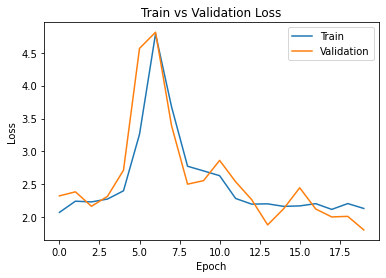

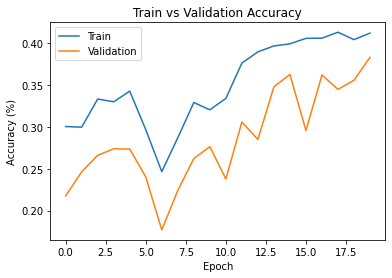

In [34]:
print("Adam optimizer using B1 = 0.8 and B2 = 0.955, learning_rate = 0.005")
adam_m2_train_acc, adam_m2_val_acc = train(LEARNING_RATE=0.005, BATCH=32)

In [41]:
# Adam optimizer hyperparameter tuning
# M1
# B1 = 0.7
# B2 = 0.888

# use model M1 from Part 2 with Adam optimizer
model = ConvNet_HyperparameterSearch(n=h1["n"], conv_three_layers=h1["conv_three_layers"], fc_two_layers=h1["fc_two_layers"])

# use Adam optimizer
adam_opt = objax.optimizer.Adam(model.vars(), beta1=0.7, beta2=0.888)

def loss_function(x, label):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()

gv = objax.GradValues(loss_function, model.vars())

def train_op(x, y, lr):
    g, v = gv(x, y)
    adam_opt(lr=lr, grads=g)
    return v

# JIT the training and prediction functions
train_op = objax.Jit(train_op, gv.vars())
predict = objax.Jit(objax.nn.Sequential([objax.ForceArgs(model), objax.functional.softmax]))

Adam optimizer using B1 = 0.7 and B2 = 0.888
Epoch 0001  Training Loss 1.53 Validation Loss 1.52 Training Accuracy 50.86 Validation Accuracy 45.32
Epoch 0002  Training Loss 1.52 Validation Loss 1.52 Training Accuracy 51.15 Validation Accuracy 45.33
Epoch 0003  Training Loss 1.51 Validation Loss 1.50 Training Accuracy 51.50 Validation Accuracy 46.00
Epoch 0004  Training Loss 1.50 Validation Loss 1.48 Training Accuracy 51.85 Validation Accuracy 46.25
Epoch 0005  Training Loss 1.50 Validation Loss 1.51 Training Accuracy 52.08 Validation Accuracy 45.62
Epoch 0006  Training Loss 1.50 Validation Loss 1.48 Training Accuracy 51.92 Validation Accuracy 47.22
Epoch 0007  Training Loss 1.51 Validation Loss 1.54 Training Accuracy 52.03 Validation Accuracy 45.72
Epoch 0008  Training Loss 1.51 Validation Loss 1.55 Training Accuracy 51.92 Validation Accuracy 44.53
Epoch 0009  Training Loss 1.51 Validation Loss 1.49 Training Accuracy 52.58 Validation Accuracy 45.60
Epoch 0010  Training Loss 1.51 Valida

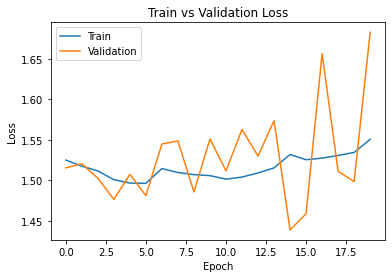

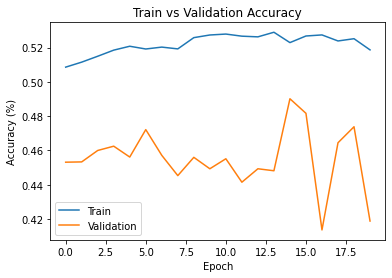

In [44]:
print("Adam optimizer using B1 = 0.7 and B2 = 0.888")
adam_m1_train_acc, adam_m1_val_acc = train(LEARNING_RATE=0.001, BATCH=32)

**Base model:** B1 = 0.9, B2 = 0.999, learning_rate = 0.001, batch size = 32, epsilon = 1e-8

Highest validation accuracy: around 46%


**M1:** B1 = 0.7, B2 = 0.888, learning_rate = 0.001, batch size = 32, epsilon = 1e-8

Highest validation accuracy: around 50%

**M2:** B1 = 0.8, B2 = 0.955, learning_rate = 0.005, batch size = 32, epsilon = 1e-8

Highest validation accuracy: around 39%

After running the base model and tuning hyperparameters in models M1 and M2, I determined that the validation accuracy is highest when using B1 = 0.7, B2 = 0.888, learning_rate = 0.001 and batch size = 32. This model achieved a validation accuracy of around 48%.

Not only did the use of the Adam optimizer siginificantly increase the validation accuracy (which almost doubled compared to in Part 2), the training procedure was executed a lot faster than with SGD.

### Question 4.2

The highest validation accuracy was achieved when using the M1 from Part 2, the Adam optimizer, and the following hyperparameter values: 

B1 = 0.7, B2 = 0.888, learning_rate = 0.001, batch size = 32, epsilon = 1e-8

Therefore, I will use the Adam optimizer to evaluate the  model's performance on the testing dataset.

In [39]:
# use model M1 from Part 2 with Adam optimizer
model = ConvNet_HyperparameterSearch(n=h1["n"], conv_three_layers=h1["conv_three_layers"], fc_two_layers=h1["fc_two_layers"])

# use Adam optimizer
adam_opt = objax.optimizer.Adam(model.vars())

def loss_function(x, label):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()

gv = objax.GradValues(loss_function, model.vars())

def train_op(x, y, lr):
    g, v = gv(x, y)
    adam_opt(lr=lr, grads=g)
    return v

# JIT the training and prediction functions
train_op = objax.Jit(train_op, gv.vars())
predict = objax.Jit(objax.nn.Sequential([objax.ForceArgs(model), objax.functional.softmax]))

In [46]:
BATCH = 32
avg_test_loss = 0
test_acc = 0
test_indices = np.arange(len(X_test))

#if not SUPPRESS_OUTPUT: print("val indices: {}".format(val_indices))
np.random.shuffle(test_indices)

for it in range(0, X_test.shape[0], BATCH):
    #PUT YOUR CODE HERE#
    batch = test_indices[it:it + BATCH]
    
    avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
    test_prediction = predict(X_test[batch]).argmax(1)

    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()

print('Model M1 using Adam optimizer test accuracy: %.2f' % (test_acc/X_test.shape[0] * 100))

Model M1 using Adam optimizer test accuracy: 42.32
